## <span style="color:red">Modèles de propagation de virus</span> 

La propagation d’un agent infectieux au sein d’une population est un phénomène dynamique : les effectifs d’individus sains et malades évoluent dans le temps, en fonction des contacts au cours desquels cet agent passe d’un individu infecté à un individu sain non immunisé, l’infectant à son tour. Un tel phénomène peut être étudié en le modélisant par des équations différentielles et en déterminant son comportement à travers la résolution numérique de ces équations

In [337]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd

from IPython.display import Image
PATH = "C:/Users/kami/Desktop/AMSE/MAG 3/projet corona/"

### <span style="color:blue"> I-Modèle SIR : Modèle de base</span> 

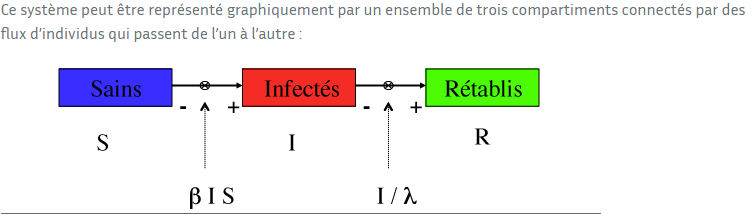

In [335]:
Image(filename = PATH + "im1.PNG")

**S : désigne les individus Sains (ou Susceptibles d’être infectés),** 


**I : désigne ceux qui sont Infectés,** 

**R : désigne ceux qui sont Rétablis (Recovered en anglais) et ne peuvent plus être infectés**

L’effectif de chacune de ces populations est évidemment variable dans le temps, modélisable de ce fait par une fonction de la variable indépendante t, le temps : S(t), I(t) et R(t). 

Si, au cours de la propagation de l’épidémie, l’effectif P de la population totale peut être considéré constant, on écrit:
**S(t) + I(t) + R(t) = P**

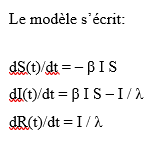

In [340]:
Image(filename = PATH + "im2.PNG")

### <span style="color:blue"> II-Modèle de base étendu : Modèle SIR prenant en compte les contaminés</span> 

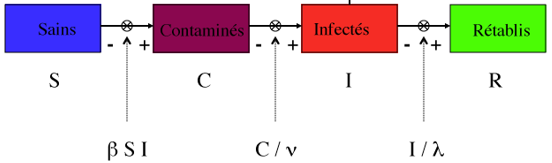

In [341]:
Image(filename = PATH + "im3.PNG")

Un nouveau compartiment peut également être introduit pour prendre en compte le fait qu’un individu peut être contaminé sans être encore contagieux.
On introduit donc une quatrième variable d’état C, dont la valeur est l’effectif des individus dans cet état contaminé non contagieux. ν est la durée, en jours, de la période d’incubation.

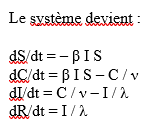

In [342]:
Image(filename = PATH + "im4.PNG")

### <span style="color:blue"> III-Modèle SIR prenant en compte les contaminés et les morts</span> 

Le modèle suppose une subdivision de la population en 5 groupes.

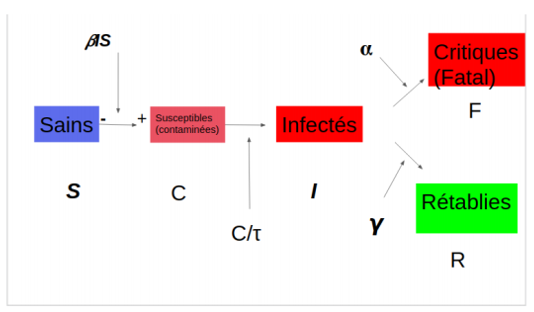

In [343]:
Image(filename = PATH + "im5.PNG")

• **S:le groupe des Sains regroupant l’ensemble des personnes saines dans la population considérée,**

• **C : ce compartiment regroupe toutes les personnes susceptibles d’être porteurs (contaminées) ou capables de développer des symptômes, car ayant été en contact avec une personne infectée,**

• **I: le compartiment des Infectés regroupe l’ensemble des personnes testées positives,** 

• **R: les Rétablies qui sont l’ensemble des personnes guéries après avoir été infectées,**

• **F: le groupe des cas critiques (fatal) regroupant les personnes déclarées positives et développant la forme la plus grave (fatale) de l’infection.**

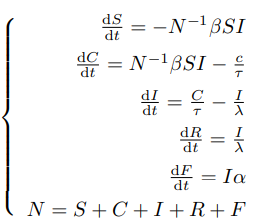

In [350]:
Image(filename = PATH + "im6.PNG")

## <span style="color:green"> Application modèle</span> 

Nous appliquons le dernier modèle sur les données dun coronavirus

In [296]:
# Lecture du fichier d'environnement
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f) #, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 20)]
              )

C:\Users\kami\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [297]:
epidemie_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,source,day
0,Anhui,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,31.8257,117.2264,01-22-2020.csv,2020-01-22
1,Beijing,Mainland China,2020-01-22 17:00:00,14.0,NaN,NaN,40.1824,116.4142,01-22-2020.csv,2020-01-22
2,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,NaN,NaN,30.0572,107.8740,01-22-2020.csv,2020-01-22
3,Fujian,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,26.0789,117.9874,01-22-2020.csv,2020-01-22
4,Gansu,Mainland China,2020-01-22 17:00:00,NaN,NaN,NaN,36.0611,103.8343,01-22-2020.csv,2020-01-22


#### Initialisation

In [304]:
country = "France"
total_population = 66_990_000

#### Processing

In [305]:
country_df = (epidemie_df[epidemie_df['Country/Region'] == country]
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )
country_df.shape

(35, 5)

In [306]:
country_df['infected'] = country_df['Confirmed'].diff()
country_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
0,France,2020-01-24,2.0,0.0,0.0,NaN
1,France,2020-01-25,3.0,0.0,0.0,1.0
2,France,2020-01-26,3.0,0.0,0.0,0.0
3,France,2020-01-27,3.0,0.0,0.0,0.0
4,France,2020-01-28,4.0,0.0,0.0,1.0


In [309]:
infected_population = country_df.loc[2:]['infected']
nb_steps = len(infected_population)

### Modèle avec paramètres par défaut

In [310]:
beta, gamma, mu,teta = [0.01, 0.1, 0.05, 0.07]

def p(t, y):
    S = y[0]
    C = y[1]
    I = y[2]
    R = y[3]
    F = y[4]
    return([-beta*S*I, beta*S*I-C*teta, C*teta-gamma*I-mu*I, gamma*I,mu*I])

In [311]:
from scipy.integrate import solve_ivp

solution = solve_ivp(p, [0, nb_steps], [total_population, 1, 1,0,0],t_eval=np.arange(0,nb_steps,1))

In [312]:
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 8260988
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])
 t_events: None
        y: array([[ 6.69900000e+07,  3.08042378e-07, -2.53818757e-07,
        -1.15198876e-06,  1.59480583e-07,  5.42984055e-07,
        -2.91353181e-07, -1.07503939e-06, -4.89281420e-07,
         1.93690595e-06, -3.45121846e-07, -4.05123463e-07,
         7.69517181e-07,  2.08221201e-06,  1.32386510e-06,
        -5.01911100e-07, -1.75763115e-07,  7.83362220e-07,
         7.01354537e-07,  1.38345757e-06,  6.77144230e-07,
        -5.74292175e-07, -7.57492415e-07,  1.97755356e-06,
        -4.68832950e-07,  1.60959655e-06,  4.74988408e-07,
         7.08278285e-07,  1.34689158e-06, -4.20289809e-07,
         2.17033927e-07,  6.47063516e-07, -5.88358471

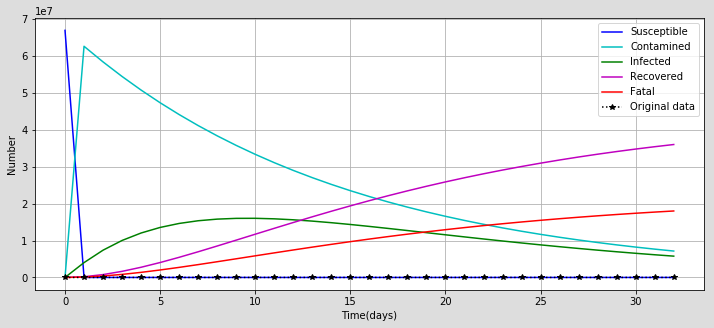

In [317]:
fig = plt.figure(figsize=(12,5),facecolor='#dddddd')
plt.plot(solution.t,solution.y[0],'b')
plt.plot(solution.t,solution.y[1],'c')
plt.plot(solution.t,solution.y[2],'g')
plt.plot(solution.t,solution.y[3],'m')
plt.plot(solution.t,solution.y[4], 'r')
plt.plot(solution.t, infected_population, "k*:")
plt.xlabel('Time(days)')
plt.ylabel('Number')
plt.grid("True")
plt.legend(["Susceptible","Contamined","Infected","Recovered","Fatal","Original data"])

### Modèle avec paramètres optimisés

In [318]:
def sumsq_error(parameters):
    beta, gamma,mu,teta = parameters
    
    def SIR(t, y):
        S = y[0]
        C = y[1]
        I = y[2]
        R = y[3]
        return([-beta*S*I, beta*S*I-C*teta, C*teta-gamma*I-mu*I, gamma*I])

    solution_optimal = solve_ivp(p, [0, nb_steps], [total_population, 1, 1,0,0],t_eval=np.arange(0,nb_steps,1))
    
    return(sum((solution_optimal.y[2]-infected_population)**2))

In [319]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.01, 0.1, 0.05, 0.07], method='Nelder-Mead')
msol.x

Wall time: 3h 2min


In [ ]:
beta, gamma,mu,teta = msol.x

def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

solution_optimal = solve_ivp(p, [0, nb_steps], [total_population, 1,1,0,0],t_eval=np.arange(0,nb_steps,1))

In [ ]:
solution_optimal

In [ ]:
fig = plt.figure(figsize=(12,5),facecolor='#dddddd')
plt.plot(solution.t,solution.y[0],'b')
plt.plot(solution.t,solution.y[1],'c')
plt.plot(solution.t,solution.y[2],'g')
plt.plot(solution.t,solution.y[3],'m')
plt.plot(solution.t,solution.y[4], 'r')
plt.plot(solution.t, infected_population, "k*:")
plt.xlabel('Time(days)')
plt.ylabel('Number')
plt.grid("True")
plt.legend(["Susceptible","Contamined","Infected","Recovered","Fatal","Original data"])